In [1]:
## Packages
'''Import all the necessary packages and modules'''

from pycroscopy.io.translators.df_utils.dm_utils import read_dm3
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from sklearn.decomposition import PCA
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter
import glob
from sklearn import preprocessing


C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\peabody\lib\site-packages\pycroscopy\__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


In [7]:
## Data Directory GUI
'''Getting data directory so data can easily be imported '''
def get_dir(new=True):
    '''Opens a window to select directory if new==False gets current directory
    Returns the directory as a string
    '''
    if new==True:
        root = Tk() # Tk() is a function in tkinter that opens a window
        root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
        root.withdraw() # closes the tkinter window since it's unnecessary
        oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
        os.chdir(root.directory) # sets new directory
        newcwd = os.getcwd() # saves new directory name as newcwd
        return root.directory
    if new==False:
        cd=os.getcwd()
        return cd
folder=get_dir()

In [10]:
## Load Data use for .csv data
''' Makes a list of all the files with the extension use * to '''

path = folder + '/*.dm3' # Change '' as needed
file_list=sorted(glob.glob(path))
list(enumerate(file_list))[0:5] # list all files and their corresponding index in the list file_list

[(0, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0001.dm3'),
 (1, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0002.dm3'),
 (2, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0003.dm3'),
 (3, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0004.dm3'),
 (4, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0005.dm3')]

In [346]:
def load_dm3(filename,get_meta=False):
    '''Loads a single dm3 into a numpy array. If get_meta=True gets all corresponding metadata aswell
    Returns an numpy array of the dm3
    '''
    image_size= read_dm3(filename)[0].shape
    image=np.zeros(image_size)
    meta=np.zeros((len(list(read_dm3(filename)[1].items())),2),dtype=np.object_)
    image[:,:]=read_dm3(filename)[0]
    meta[:,:]=list(read_dm3(filename)[1].items())
    if get_meta==True:
        return image, meta
    return image

In [363]:
def outliers(image,quart=5, num_stdev=2, get_cutoff=False, dist='Normal',index=False):
    """Check if value is an outlier based on standard deviations
    quart and num_stdev determine the qualifiers for the outlier (mean +- 1.5*(inner quartile) and mean +- num_stdev *std)
    get_cutoff=True gets the value of the cutoff as determined by num_stdev and quart
    Use dist='Normal' for normal distributions and dist=any other string if not normal dist
    returns boolean array the same size as image where each element is True if an outlier
    
    """

    if dist=='Normal':
        m=np.mean(image)
        std=np.std(image)
        cutoff=num_stdev*std
        lower, upper = m-cutoff, m+cutoff
        outs =np.logical_or(image<=lower,image>=upper)
        if index==False:
            return outs
        if get_cutoff==False:
            return outs
        
        return outs, (lower, upper)
    else:
        """Check if value is an outlier based on percentiles"""
        uquart=100-quart
        q25, q75 = np.percentile(image, quart), np.percentile(image, uquart)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outs =np.logical_or(image<=lower,image>=upper)  
        if index==False:
            return np.argwhere(outs)
        if get_cutoff==False:
            return outs

        return outs, (lower, upper)


def local_mean(matrix, x_axis, y_axis, NN=1):
    '''Gets the local mean around a specific index in the matrix
        with NN 1=3x3 -center point = 8 points NN; 2=5x5 -center pt = 24 points!
        Now works with any size by folding around at edges
        Returns the local mean for the specified x and y
        '''

    local_data=[]
    numb=[]
    nsize=matrix.shape[0]-1
    msize=matrix.shape[1]-1
    for n in range(-NN, NN+1,1) :
        for m in range(-NN, NN+1,1):
            if m==0 and n==0:
                continue
                
            if  x_axis+n>nsize and   y_axis+m>msize:  #Cycles around far corner back to 0,0 for arbitrary size
                k = (x_axis+n) 
                k = k % nsize-1
                l = (y_axis+m) 
                l = l % msize-1
                local_data.append(matrix[k, l])
                numb.append([k, l])
                continue
            
            if x_axis+n>nsize:
                k = x_axis+n 
                k = k% nsize-1
                local_data.append(matrix[k, y_axis + m])
                numb.append([k,y_axis + m])
                continue
            if   y_axis+m>msize:
                l = (y_axis+m) 
                l = l % msize-1
                local_data.append(matrix[x_axis +n, l])
                numb.append([x_axis, l])
                continue
          
            local_data.append(matrix[x_axis+n,y_axis+m])
            numb.append([x_axis+n,y_axis+m])
             
    loc_mean=np.mean(local_data)        
        
    return loc_mean    
    
def remove_outliers(image,NN=1,quart=5,num_stdev=2, get_out=False, dist='Normal'):
    '''Takes an image (numpy array) and replaces outliers (determined by outliers function)
    with the local means determined by the local mean function
    Returns the image with the outliers removed.
    If get_out=True it returns the values of the outliers from the image
    '''
    if dist=='Normal':
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed
    else:
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev, get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed

In [364]:
def diff_outliers(image,quart=5,num_stdev=2,dist='Normal',axis='both',index=False):
    ''' Returns an array of shape image with the outliers (based on X and Y derivatives aka slopes)
    of the image of type True. Outliers are designated by outliers function.
    axis determines the direction of derivate and selecting both combines both derivatives
    If index=True, the function returns the index of where the outliers are in the image.
    '''
    if image.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    mat=image
    if axis=='both':
        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)
        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')
        
        diffy= np.logical_and(diffy1,diffy1a)
               
        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)
        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:  
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        diffx= np.logical_and(diffx1,diffx1a)
        

        diff=np.logical_or(diffx,diffy)
        if index==True:
            return np.argwhere(diff)
        return diff
        
    if axis==0:

        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)

        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')
        
        diffy= np.logical_and(diffy1,diffy1a)
        if index==True:
            return np.argwhere(diffy)
        return diffy
    if axis==1:
    
        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)

        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:  
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        
        diffx= np.logical_and(diffx1,diffx1a)
        if index==True:
            return np.argwhere(diffx)
        return diffx
def remove_diff_outliers(image,NN=1,quart=5,num_stdev=2,dist='Normal',axis='both',get_out=False, num_out=False):
    '''Removes outliers based on the slopes using the diff_outlier function
    Returns the original image with the difference outliers replaced by the local mean
    if num_out =True it returns number of outliers
    If get_out=True it returns the values of the outliers from the image
    
    
    '''
    outlier_index=diff_outliers(image, quart=quart,num_stdev=num_stdev, dist=dist,axis=axis, index=True)
    outliers_removed=image.copy()
    for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
        loc_mean=local_mean(image, i, j, NN)
        outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean
    if num_out==True:
        return outlier_index.shape[0]
    if get_out ==True:
        return outliers_removed, outliers_removed[outlier_index]

    return outliers_removed

In [367]:
remove_diff_outliers(orig,num_stdev=1,axis=1,num_out=True)

2203

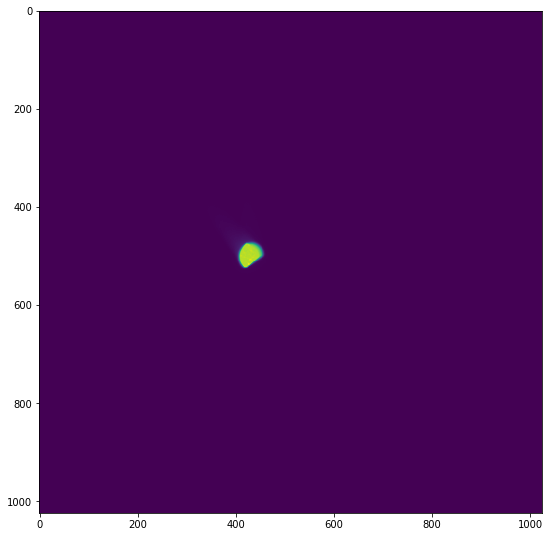

In [342]:
orig=test
filt=remove_diff_outliers(orig,num_stdev=.1)
plot_easy(filt)

In [323]:
filt.shape

(1024, 1024)

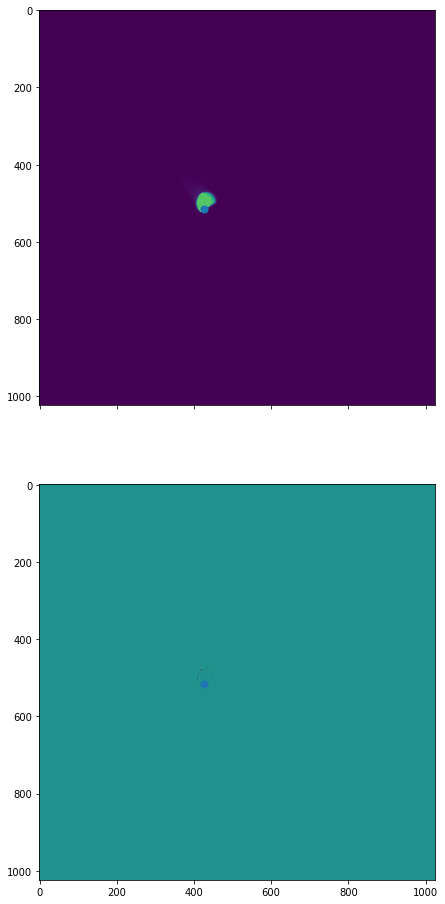

In [316]:
def compare_filtered(orig, maxes=True):
    '''Plots original vs filtered - original'''
    filt=remove_diff_outliers(orig)
    plt.rcParams['figure.figsize'] = (9,16)
    fig, (ax1,ax2)=plt.subplots(2, sharex=True)

    ax1.imshow(orig)
    ax2.imshow(filt-orig)
    max_x,max_y=np.unravel_index(np.argmax(filt),dims=(filt.shape[0],filt.shape[1]))
    max_x1,max_y1=np.unravel_index(np.argmax(orig),dims=(orig.shape[0],orig.shape[1]))
    if maxes==True:
        ax1.scatter(max_y,max_x,50)
        ax2.scatter(max_y1,max_x1,50)
compare_filtered(orig)

In [319]:
def normalize_01(matrix,copy=True):
    if copy==True:
        m=matrix.copy()
    else:
        m=matrix
    m[m<0]=0
    m/=np.max(m)
    return m

def plot_easy(image):
    plt.rcParams['figure.figsize'] = (9,16)
    plt.imshow(image)
def mask_maker(mat,stds=3):
    mask=~(mat>np.mean(mat)+stds*np.std(mat))|(mat<np.mean(mat)-stds*np.std(mat))
    return mask
def masker(orig, mask):
    a=np.ma.masked_where(mask,orig)
    return a

def plot_masked(orig, mask):
    a=masker(mask, orig)
    plot_easy(a)
def plot_compare(mat1,mat2,diff=False):
    plt.rcParams['figure.figsize'] = (9,16)
    fig, (ax1,ax2)=plt.subplots(2, sharex=True)
    ax1.imshow(mat1)
    ax1.set_title('Matrix 1')
    if diff==False:
        ax2.imshow(mat2)
        ax2.set_title('Matrix 2')
    else:
        ax2.imshow(mat2-mat1)
        ax2.set_title('Matrix 1 - Matrix 2')


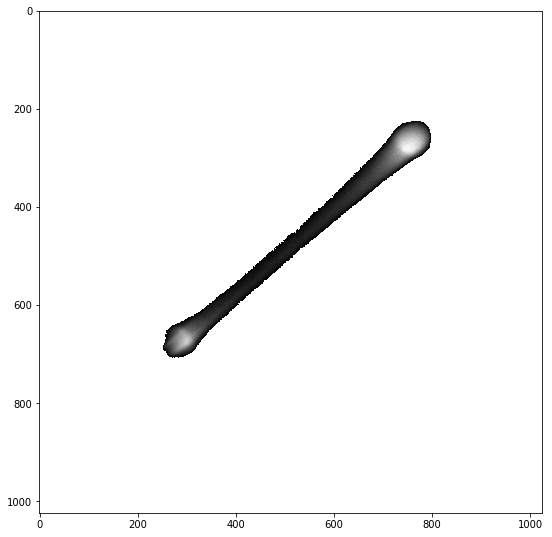

In [513]:
im=data_stack[:,:,40]
mask1=mask_maker(im,stds=3)
plot_easy(masker(im,mask1))

In [491]:
def positions_nonzero(masked_image):
    y,x=np.ma.nonzero(masked_image)
    return y,x
def position_means(masked_image):
    b,a=positions_nonzero(masked_image)
    a_m=np.nanmean(a)
    b_m=np.nanmean(b)
    return b_m,a_m
def positions_to_vector(masked_image):
    y,x=positions_nonzero(masked_image)
    X=np.stack((x,y)).T
    return X
def scaled_pos_vector(masked_image):
    V=positions_to_vector(masked_image)
    X=preprocessing.scale(V.astype(np.float64))
    return X
# V=scaled_pos_vector(masked_im)
def splot_scaled(masked_image):
    V=scaled_pos_vector(masked_image)
    fig=plt.subplot()
    fig.scatter(V[:,0],V[:,1])
def remove_outliers_fast(mat,lower=10,upper=90,copy=True):
    if copy==True:
        m=mat.copy()
    else:
        m=mat
    lower,upper =outliers(mat,lower,upper)
    mat[mat<lower]=np.mean(mat[(lower<mat) &(mat<upper)])
    mat[mat>upper]=np.mean(mat[(lower<mat) &(mat<upper)])
    return mat
def filt_norm(mat):
    normed=normalize_01(mat)
    filt=denoise_bilateral(normed,multichannel=False) 
    norm=normalize_01(filt,copy=False)
    return norm

def cleaner_fast(mat,lower=10,upper=90,copy=True):
    if copy==True:
        m=mat.copy()
    else:
        m=mat
    out_m=remove_outliers_fast(m,lower,upper,copy=False)
    cleaned_mat=filt_norm(out_m)
    return cleaned_mat
def cleaner_slow(mat,lower=10,upper=90,size=3,copy=True):
    if copy==True:
        m=mat.copy()
    else:
        m=mat
    out_m=remove_outliers(m,lower,upper,size,copy)
    cleaned_mat=filt_norm(out_m)
    return cleaned_mat

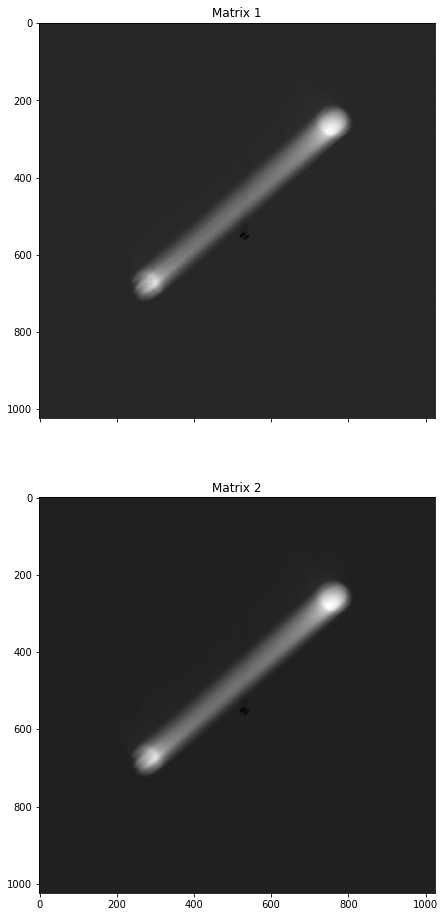

In [515]:
im=data_stack[:,:,40]
mask1=mask_maker(im,stds=3)
plot_compare(im,cleaner_slow(im))

In [453]:
def pca_vectors(V):
    pca=PCA()
    pca.fit(V)
    axis=pca.components_.T
    axis/=axis.std()
    x_axis, y_axis=axis
    return x_axis, y_axis
def splot_pca(masked_image):
    V=scaled_pos_vector(masked_image)
    x,y=pca_vectors(V)
    fig=plt.subplot()
    fig.scatter(V[:,0],V[:,1])
    plt.quiver(0,0,x,y,zorder=11,width=.01,scale=6,color='r')

In [437]:
def plot_maskim_pca(masked_image):
    y_m,x_m=position_means(masked_image)
    X=scaled_pos_vector(masked_image)
    x_axis,y_axis=pca_vectors(X)
    plt.imshow(masked_image)
    colors=np.array(['r','b'])
    plt.plot(x_axis[0], color=colors[0])
    plt.plot(y_axis*.1, color=colors[1])
    plt.quiver(x_m,y_m,x_axis,y_axis,scale=5,width=.005,color=colors)
    legend = plt.legend(['PCA 1', 'PCA 2'], loc='upper right')

In [509]:
def find_pca_vectors_plot(im, mask, lower=10,upper=90):
    filt=cleaner_fast(im,lower,upper,copy=True)
    masked_image=masker(filt,mask)
    y_m,x_m=position_means(masked_image)
    X=scaled_pos_vector(masked_image)
    x_axis,y_axis=pca_vectors(X)
    return x_axis, y_axis , masked_image
def find_pca_vectors(im, mask, lower=10,upper=90):
    filt=cleaner_fast(im,lower,upper,copy=True)
    plot_compare(im,filt)
    masked_image=masker(filt,mask)
    y_m,x_m=position_means(masked_image)
    X=scaled_pos_vector(masked_image)
    x_axis,y_axis=pca_vectors(X)
    return x_axis, y_axis

(array([-1.15470054, -1.15470054]), array([ 1.15470054, -1.15470054]))

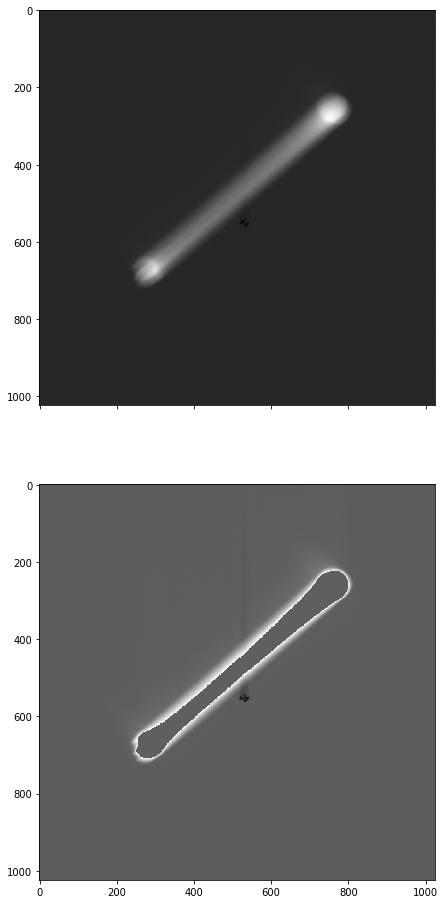

In [510]:
im=data_stack[:,:,40]
mask1=mask_maker(im,stds=3)
find_pca_vectors(im,mask1)

In [439]:
def plot_im_pca(im,mask,lower=10,upper=90,plottrue=True):
    x,y, maskim= find_pca_vectors_plot(im,mask,lower,upper)
    y_m,x_m=position_means(maskim)
    if plottrue==True:
        plt.imshow(im)
    else:
        plt.imshow(maskim)
    colors=np.array(['r','b'])
    plt.plot(x_axis[0], color=colors[0])
    plt.plot(y_axis*.1, color=colors[1])
    plt.quiver(x_m,y_m,x,y,scale=5,width=.005,color=colors)
    legend = plt.legend(['PCA 1', 'PCA 2'], loc='upper right')

136


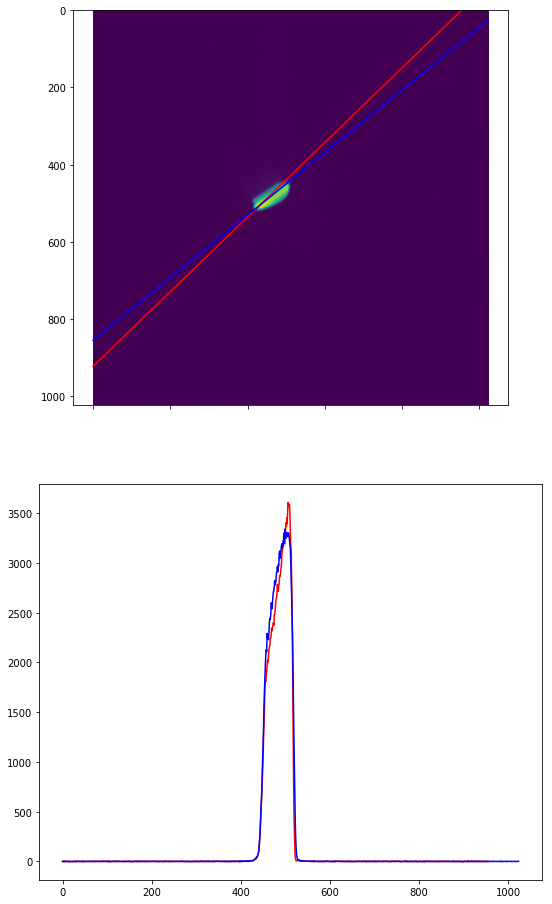

In [297]:

## Build up array of slopes and lines
z=data_stack[:,:,4]
max_y,max_x=np.unravel_index(np.argmax(z),dims=(z.shape[0],z.shape[1]))
angles=np.arange(0,181,1)
dslope=np.tan(angles*np.pi/180)
test_x=np.arange(0,z.shape[0],1)
test_y=np.empty((0,test_x.shape[0]))

for ms in dslope:
    new_line=ms*(test_x-max_x)+max_y
    test_y=np.append(test_y,[new_line],axis=0)

fig, (ax,ax1) = plt.subplots(2, sharex=True)
ax.imshow(z)
search_lines=[]
zi=[]
select_range=[]
for line in range(test_y.shape[0]):
    select_ys=np.where(((test_y[line,:]>0) & (test_y[line,:]<z.shape[1])))
    select_range.append(select_ys)
    search_lines.append(np.squeeze(test_y[line,select_ys]))
    zi.append(z[test_x[select_ys].astype(np.int), search_lines[line].astype(np.int)])
#     ax.plot(test_x[select_ys],search_lines[line])   
line_int=np.empty([0,len(zi)])
line_width_ls=[]
b=0
metric=np.empty([])
for a,line in enumerate(zi):
#     print(a)
    thresh=10
    if np.all(line[:]<thresh):
        line_int=np.append(line_int,0)
        metric=np.append(metric,0)
    else:
#         print(a)
        
        line_width_ls.append((a,b))
        b+=1
        lin_width=len(np.where(line>thresh)[0])
        metric=np.append(metric, np.max(line))
        line_int=np.append(line_int,lin_width)

ms_loc=np.argmax(metric)
ax.plot(test_x[select_range[ms_loc]],search_lines[ms_loc],'r')
ax.plot(test_x[select_range[141]],search_lines[141],'b')
ax1.plot(test_x[select_range[ms_loc]],zi[ms_loc],'r')
ax1.plot(test_x[select_range[141]],zi[141],'b')
print(ms_loc)
best_slope=dslope[ms_loc]

In [272]:
line_int[41]*np.max(zi[141])-line_int[ms_loc]**2*np.max(zi[ms_loc])

-35727353.133320265

In [256]:
np.max(zi[65])

3.0

278


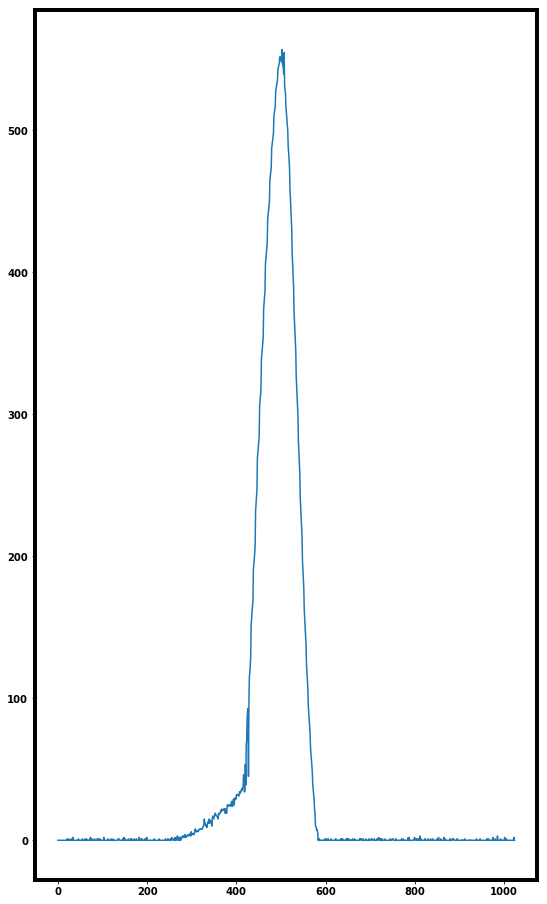

In [239]:
num1=142
test=np.where(zi[num1]>thresh)[0]
print(len(test))
fig, ax=plt.subplots()
ax.plot(test_x[select_range[num1]],zi[num1])

In [201]:
list(zip(line_width_ls,line_int))

[((0, 0), 22.0),
 ((1, 1), 20.0),
 ((2, 2), 17.0),
 ((3, 3), 15.0),
 ((4, 4), 13.0),
 ((5, 5), 12.0),
 ((6, 6), 10.0),
 ((7, 7), 7.0),
 ((8, 8), 5.0),
 ((9, 9), 3.0),
 ((10, 10), 1.0),
 ((65, 11), 45.0),
 ((66, 12), 155.0),
 ((67, 13), 180.0),
 ((68, 14), 171.0),
 ((69, 15), 150.0),
 ((70, 16), 126.0),
 ((71, 17), 107.0),
 ((72, 18), 93.0),
 ((73, 19), 84.0),
 ((74, 20), 75.0),
 ((75, 21), 69.0),
 ((76, 22), 63.0),
 ((77, 23), 57.0),
 ((78, 24), 53.0),
 ((79, 25), 50.0),
 ((80, 26), 45.0),
 ((81, 27), 43.0),
 ((82, 28), 40.0),
 ((83, 29), 38.0),
 ((84, 30), 36.0),
 ((85, 31), 33.0),
 ((86, 32), 31.0),
 ((87, 33), 29.0),
 ((88, 34), 25.0),
 ((89, 35), 24.0),
 ((90, 36), 22.0)]

In [118]:
best_slope
test_ms=np.where(dslope==best_slope)

In [119]:
dslope[np.squeeze(test_ms)]

0.48773258856586144

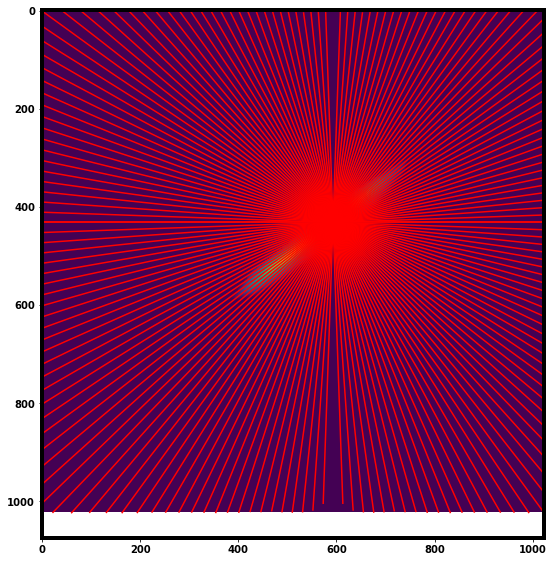

In [114]:
fig, ax = plt.subplots()
ax.imshow(z)
zi=[]
select_ys=[]
for l in range(len(dslope)):
#     print(l)
    select_ys.append(np.where(((test_y[l,:]>0) & (test_y[l,:]<z.shape[1]))))
    zi.append(np.squeeze(z[test_x[select_ys[l]].astype(np.int), test_y[l,select_ys[l]].astype(np.int)]))
    
    ax.plot([test_x[select_ys[l]][0], test_x[select_ys[l]][-1]], [test_y[l,select_ys[l]][0][0], test_y[l,select_ys[l]][0][-1]], 'r-')
# ax.plot([test_x[select_ys][0], test_x[select_ys][-1]], [search_lines[best_slope], search_lines[best_slope]], 'ko-',alpha=alph)
    

In [113]:
select_ys[ms_loc]

IndexError: tuple index out of range

0.48773258856586144

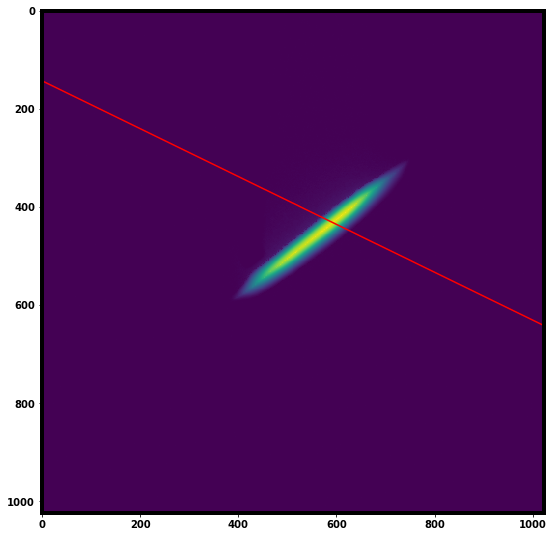

In [120]:
fig, ax=plt.subplots()
ms_loc=np.squeeze(test_ms)
ax.imshow(z)
ax.plot([test_x[select_ys[ms_loc]][0], test_x[select_ys[ms_loc]][-1]], [test_y[ms_loc,select_ys[ms_loc]][0][0], test_y[ms_loc,select_ys[ms_loc]][0][-1]], 'r-')

best_slope

-1.0355303137905703


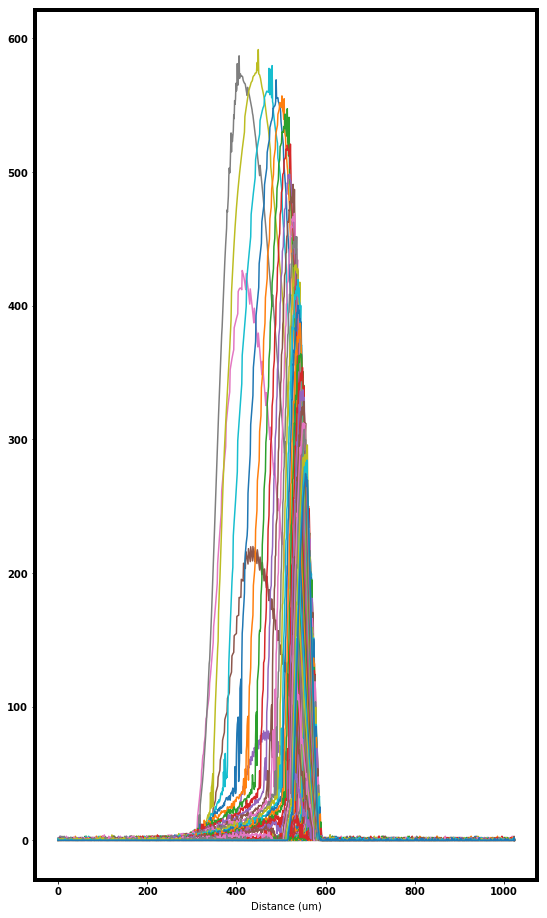

In [60]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
plt.rcParams['figure.figsize'] = (9,16)

fig, axs = plt.subplots()
line_sum=[]
for l in range(len(dslope)):
    X= test_x[select_ys[l]]
    axs.plot(X,zi[l])
#     ax.set_title(file_list[k].split('\\')[1],fontsize=10)
    axs.set_xlabel('Distance (um)')
    line_sum.append(np.sum(zi[l]))
print(dslope[np.argmax(line_sum)])

In [254]:
## Find best slope for 1 file
z=data_stack[:,:,0]
for l in range(len(search_ms)):
    zi = z[test_x[select_ys].astype(np.int), [:,l].astype(np.int)]   

SyntaxError: invalid syntax (<ipython-input-254-69604e3b211f>, line 4)

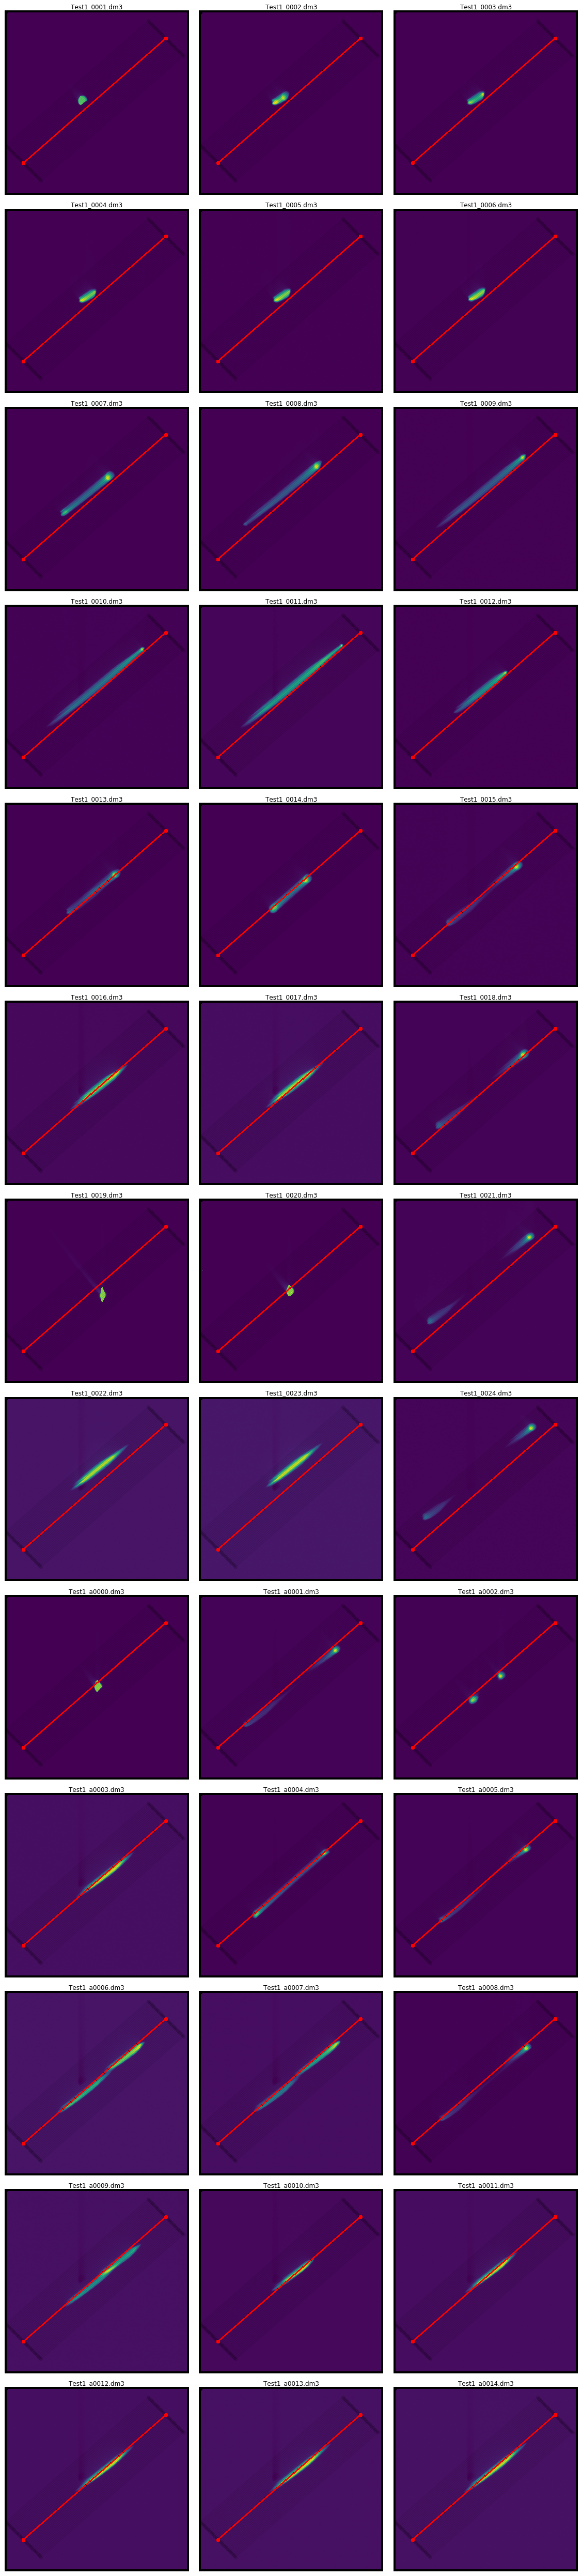

In [482]:
## Draw Line to get data
# Make a line with "num" points...
x0, y0 = 100, 850 # These are in _pixel_ coordinates!!
x1, y1 = 900, 150
num = 1000
mag=6000
l_length=((x1-x0)**2+(y1-y0)**2)**.5
d_perpix=24 #um
d_actual=l_length/(num)*d_perpix/mag
width=601 #odd number only
m=(y1-y0)/(x1-x0)
m_perp=-1/m
x=np.zeros((num,width))
y=np.zeros((num,width))
for n in np.arange(0,int(width/2+1),20):
    x0_edgep=x0+(n/2)/(1+m_perp**2)**.5
    x0_edgen=x0-(n/2)/(1+m_perp**2)**.5
    x1_edgep=x1+(n/2)/(1+m_perp**2)**.5
    x1_edgen=x1-(n/2)/(1+m_perp**2)**.5
    y0_edgep=y0+(n/2)/(1+m_perp**2)**.5
    y0_edgen=y0-(n/2)/(1+m_perp**2)**.5
    y1_edgep=y1+(n/2)/(1+m_perp**2)**.5
    y1_edgen=y1-(n/2)/(1+m_perp**2)**.5
    xp, yp = np.linspace(x0_edgep, x1_edgep, num), np.linspace(y0_edgep, y1_edgep, num)
    xn, yn = np.linspace(x0_edgen, x1_edgen, num), np.linspace(y0_edgen, y1_edgen, num)
    index=int(-n+width/2)
#     print(n,index)
    x[:,int(-n+width/2)]=xn
    x[:,int(n+width/2)]=xp
    y[:,int(-n+width/2)]=yn
    y[:,int(n+width/2)]=yp
#     print(y0_edgep,y1_edgep,y0_edgen,y1_edgen)
    
# z=data_stack[:,:,1]
# Extract the values along the line, using cubic interpolation

#-- Plot...
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,n_rows*16/3)
fig, axs = plt.subplots(nrows=n_rows, ncols=3,
                        subplot_kw={'xticks': [], 'yticks': []})
# axs.imshow(z)
alph=.1
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.01, wspace=0.01)
z_lave = np.zeros((num,len(file_list)))
for ax,k in zip(axs.flat,range(len(file_list))):
    z=data_stack[:,:,k]
    ax.imshow(z)
    ax.set_title(file_list[k].split('\\')[1],fontsize=12)
    z_lines=np.zeros(x.shape)
    z_lines_reduced=[]
    for l in range(width):
        zi = z[x[:,l].astype(np.int), y[:,l].astype(np.int)]
        ax.plot([x0, x1], [y0, y1], 'ro-')
        ax.plot([x[0,l], x[-1,l]], [y[0,l], y[-1,l]], 'ko-',alpha=alph)
        z_lines[:,l]=zi
        if np.sum(z_lines[:,l],axis=0)>0: # remove excess lines from average response
            z_lines_reduced.append(z_lines[:,l])
    z_lines_reduced=np.asarray(z_lines_reduced)    
    z_lave[:,k]=np.mean(z_lines_reduced, axis=0)
        
#     ax2.plot(zi)
plt.tight_layout()
plt.show()

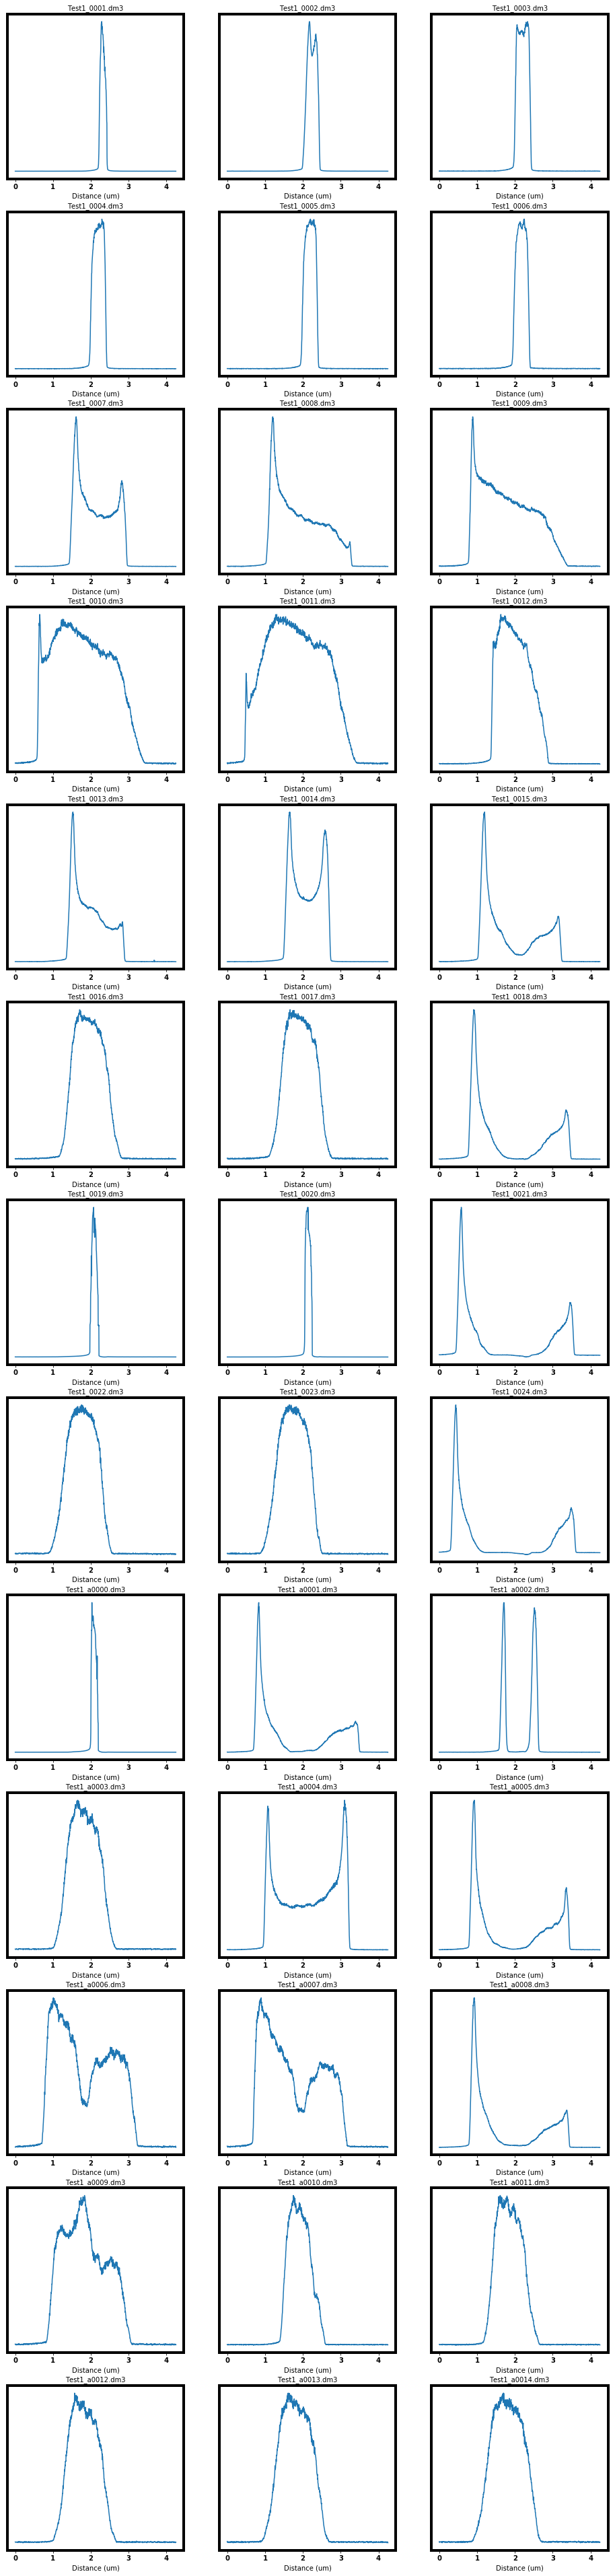

In [483]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,n_rows*16/3)
X= np.arange(0,num)*d_actual
fig, axs = plt.subplots(nrows=n_rows, ncols=3,
                        subplot_kw={ 'yticks': []})
for ax,k in zip(axs.flat,range(len(file_list))):
    ax.plot(X,z_lave[:,k])
    ax.set_title(file_list[k].split('\\')[1],fontsize=10)
    ax.set_xlabel('Distance (um)')

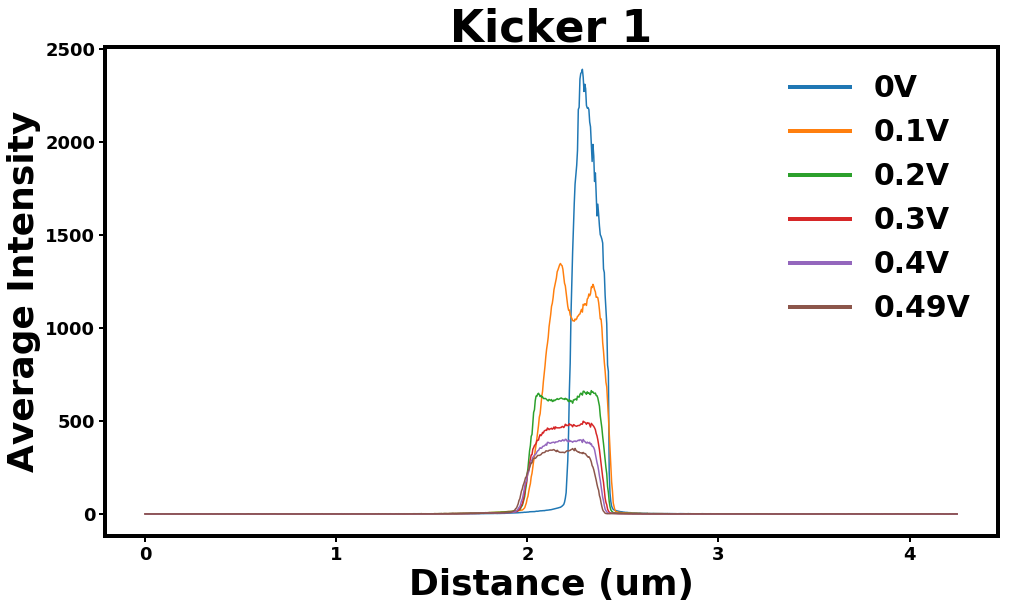

In [484]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['0V','0.1V','0.2V','0.3V','0.4V','0.49V']
fig, ax1 = plt.subplots()
plt.title('Kicker 1', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)

for k in range(6):
    ax1.plot(X,z_lave[:,k],label=Labels[k])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

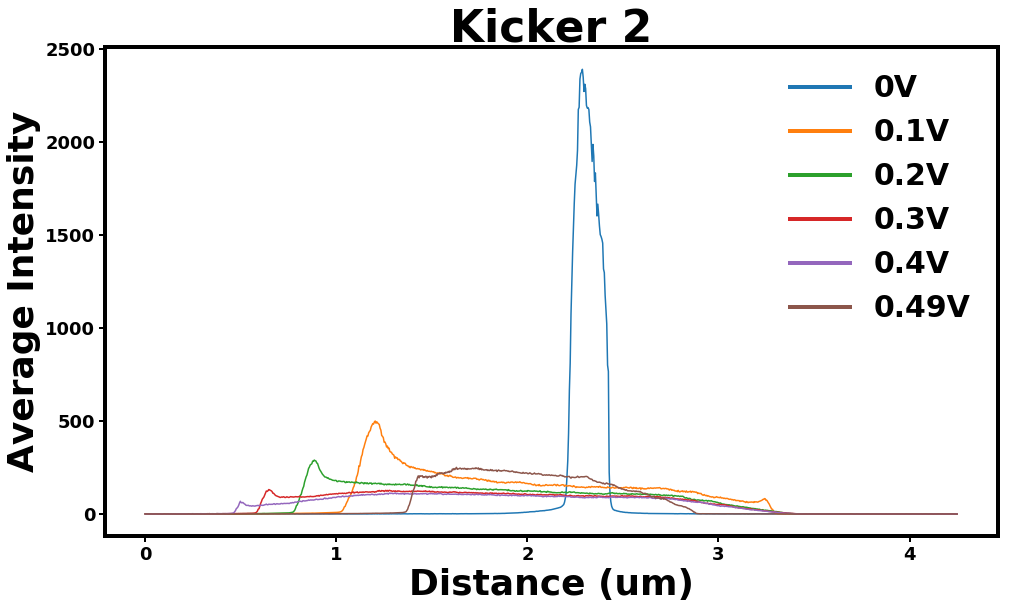

In [485]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['0V','0.1V','0.2V','0.3V','0.4V','0.49V']
fig, ax1 = plt.subplots()
plt.title('Kicker 2', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[0,7,8,9,10,11]
for a,k in enumerate(data_select):
    ax1.plot(X,z_lave[:,k],label=Labels[a])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

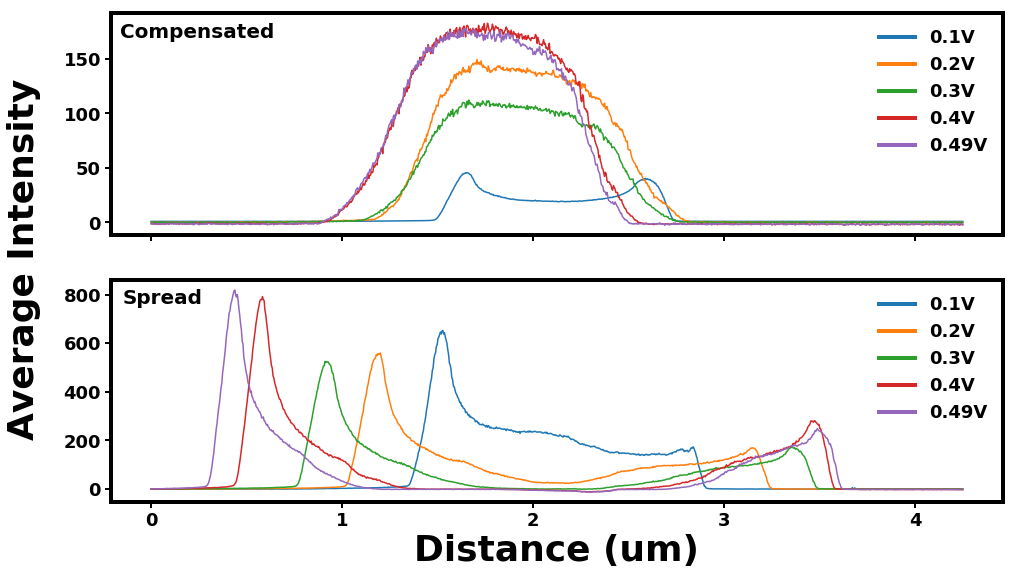

In [486]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

# Labels=['0.1V','0.2V','0.3V','0.4V','0.49V']
Labels=['0.1V','0.1V','0.2V','0.2V','0.3V','0.3V','0.4V','0.4V','0.49V','0.49V']
# Labels=['13','14','15','16','18','17','21','22','24','23']
fig, (ax1,ax2) = plt.subplots(2, sharex=True)
# plt.title('Both Kickers', fontsize=44, fontweight='bold')
ax2.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
fig.text(0.05, 0.5,'Average Intensity', ha='center', va='center', rotation='vertical', fontsize=36, fontweight='bold')
fig.text(0.2, 0.85,'Compensated', ha='center', va='center', fontsize=20, fontweight='bold')
fig.text(0.17, 0.44,'Spread', ha='center', va='center', fontsize=20, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)

ax2.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax2.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[13,14,15,16,18,17,21,22,24,23]
b=0
c=0
for a,k in enumerate(data_select):
    if a%2:
        ax1.plot(X,z_lave[:,k-1],label=Labels[a])
        b+=1
    else:
        ax2.plot(X,z_lave[:,k-1],label=Labels[a])
        c+=1
leg1=ax1.legend(fontsize=18, loc='best', frameon=False)
leg2=ax2.legend(fontsize=18, loc='best', frameon=False)
for legobj in leg1.legendHandles:
    legobj.set_linewidth(4.0)
    
for legobj in leg2.legendHandles:
    legobj.set_linewidth(4.0)

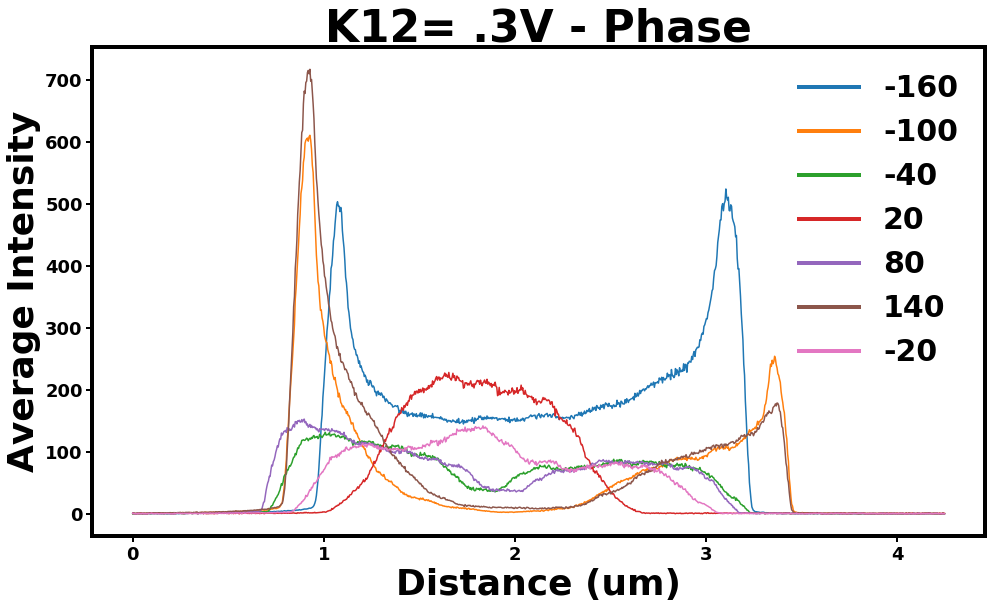

In [487]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['-160','-100','-40','20','80','140','-20']
fig, ax1 = plt.subplots()
plt.title('K12= .3V - Phase', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[28,29,30,27,31,32,33]
for a,k in enumerate(data_select):
    ax1.plot(X,z_lave[:,k]-min(z_lave[:,k]), label=Labels[a])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

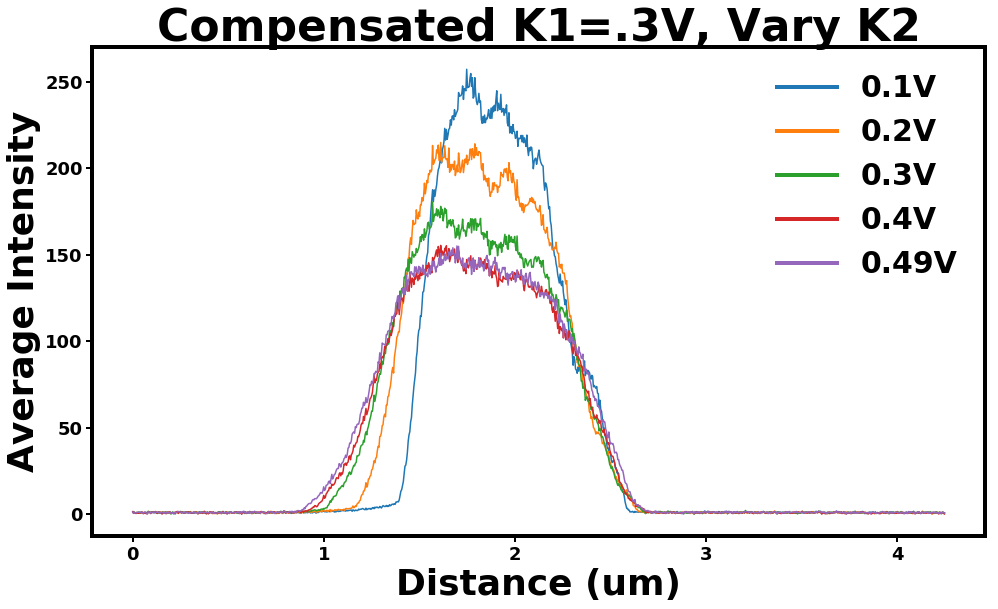

In [489]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['0.1V','0.2V','0.3V','0.4V','0.49V']
fig, ax1 = plt.subplots()
plt.title('Compensated K1=.3V, Vary K2', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[34,35,36,37,38]
for a,k in enumerate(data_select):
    ax1.plot(X,z_lave[:,k]-min(z_lave[:,k]), label=Labels[a])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

In [472]:
z_lines_reduced=[]
for x in range(z_lines.shape[1]):
    if np.sum(z_lines[:,x],axis=0)>0:
        z_lines_reduced.append(z_lines[:,x])
z_lines_reduced=np.asarray(z_lines_reduced)        
    

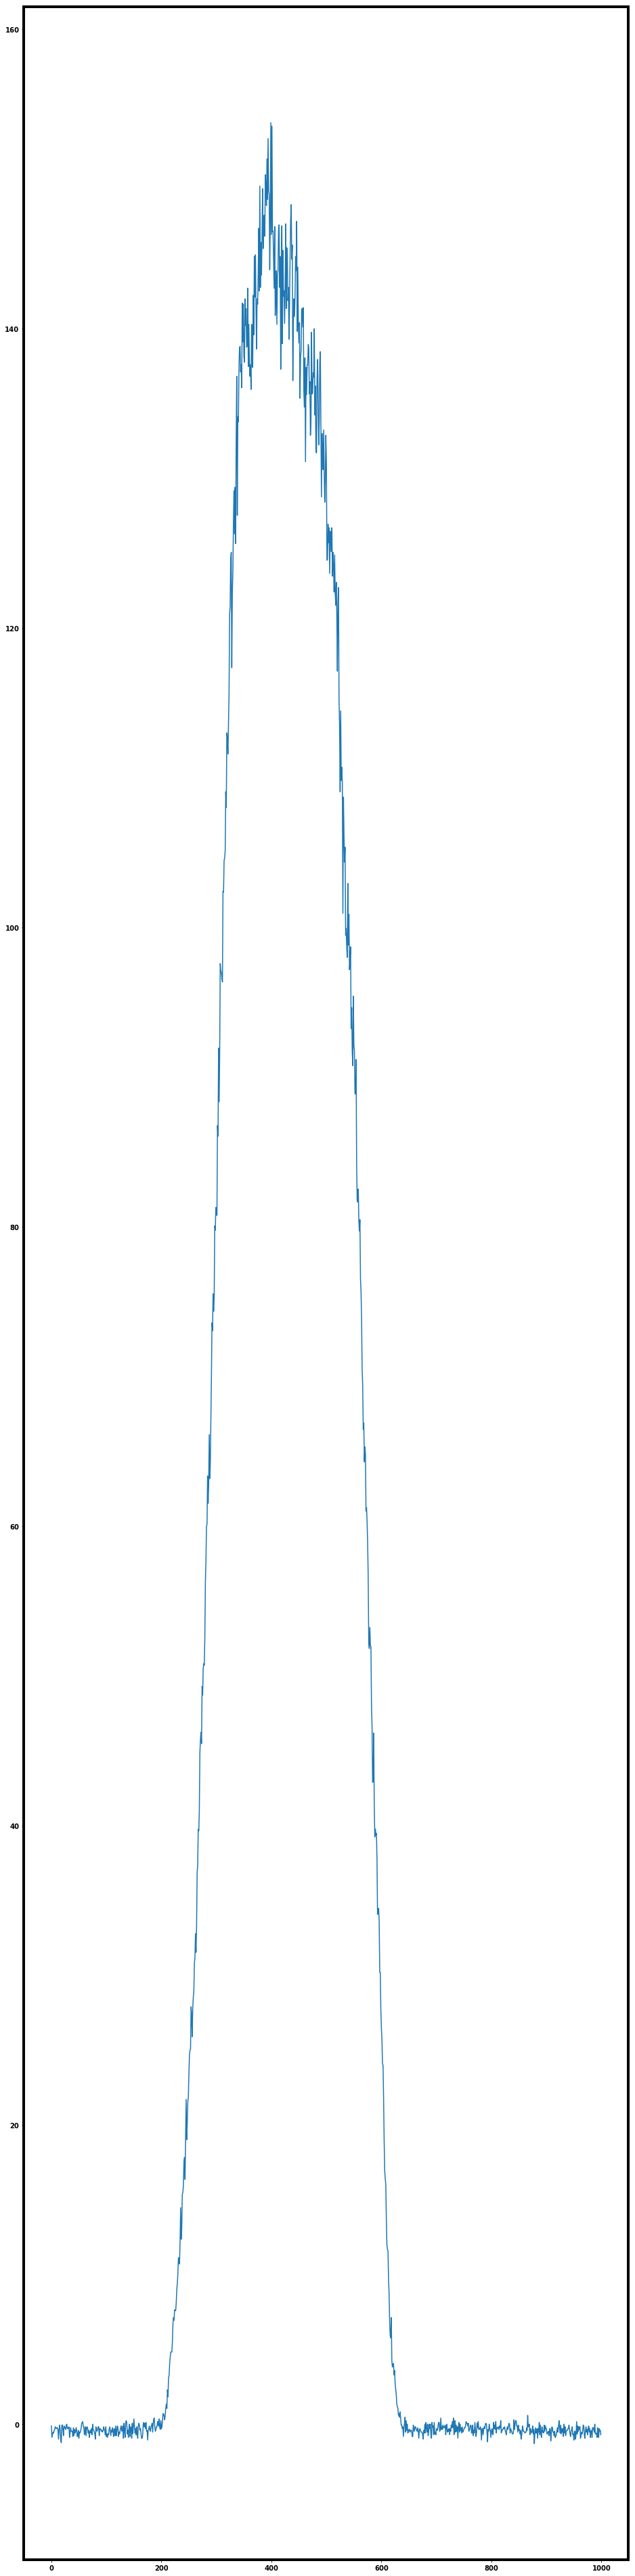

In [480]:
fig, ax = plt.subplots()
ax.plot(np.mean(z_lines_reduced,axis=0))

In [8]:
meta_stack[:,:,0]

array([['Acquisition-Device-Active-Size-(pixels)', (1024, 1024)],
       ['Acquisition-Device-Camera-Number', 0],
       ['Acquisition-Device-CCD-Pixel-Size-(um)', (24.0, 24.0)],
       ['Acquisition-Device-Configuration-Transpose-Diagonal-Flip',
        False],
       ['Acquisition-Device-Configuration-Transpose-Horizontal-Flip',
        True],
       ['Acquisition-Device-Configuration-Transpose-Vertical-Flip', True],
       ['Acquisition-Device-Name', ' MSC'],
       ['Acquisition-Device-Source', ' MSC'],
       ['Acquisition-Frame-Area-Transform-Class-Name',
        'cm_acquisitiontransform_list'],
       ['Acquisition-Frame-Area-Transform-Transform-List-Binning',
        (1, 1)],
       ['Acquisition-Frame-Area-Transform-Transform-List-Class-Name',
        'cm_acquisitiontransform'],
       ['Acquisition-Frame-Area-Transform-Transform-List-Sub-Area-Adjust',
        (0, 0, 0, 0)],
       ['Acquisition-Frame-Area-Transform-Transform-List-Transpose-Diagonal-Flip',
        False],
    

In [584]:
def diff_mat(matrix):
    
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    
    nsize=matrix.shape[0]
    msize=matrix.shape[1]
    diffy=[]
    diffx=[]
    for y in range(nsize):
        row_diff = matrix[y,:]-matrix[y-1,:]
        diffy.append(row_diff)
    for x in range(msize):
        col_diff = matrix[:,x]-matrix[:,x-1]
        diffx.append(col_diff)
    diffy = np.array(diffy)
    diffx = np.transpose(np.array(diffx)) 
    
    return diffy, diffx

In [585]:
%timeit remove_outliers(im)

12.7 s ± 2.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [583]:
%timeit remove_outliers(im)

18.5 s ± 785 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [576]:
def diff_mat(matrix, copy=False):
    if copy ==True:
        mat=matrix.copy()
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    mat=matrix
    A=np.expand_dims(mat[0,:],axis=0)
    mat0=np.concatenate((mat,A),axis=0)
    
    B=np.expand_dims(mat[:,0],axis=1)
    mat1 = np.concatenate((mat,B),axis=1)
    
    diffy = np.diff(mat0,axis=0)
    diffx = np.diff(mat1,axis=1)
    
    return diffy, diffx

In [577]:
a,b=diff_mat(im)
print(a.shape,b.shape,im.shape)

(1024, 1024) (1024, 1024) (1024, 1024)


In [581]:
A=np.array([[1,8,6],[7,100,3],[4,2,9]])
a,b=diff_mat(A)
# print(a.shape,b.shape)
print(A,b)

[[  1   8   6]
 [  7 100   3]
 [  4   2   9]] [[  7  -2  -5]
 [ 93 -97   4]
 [ -2   7  -5]]


In [563]:
A=np.array([[1,8,6],[7,5,3],[4,2,9]])
Av=np.expand_dims(A[:,0],axis=1)
np.concatenate((A,Av),axis=1)

array([[1, 8, 6, 1],
       [7, 5, 3, 7],
       [4, 2, 9, 4]])

In [568]:
A=im
Av=np.expand_dims(im[:,0],axis=1)
np.concatenate((im,Av),axis=1)

array([[0.15215622, 0.15215622, 0.15174939, ..., 0.15174939, 0.15174939,
        0.15215622],
       [0.15093572, 0.15174939, 0.15215622, ..., 0.15215622, 0.15174939,
        0.15093572],
       [0.15215622, 0.15052889, 0.15174939, ..., 0.15093572, 0.15093572,
        0.15215622],
       ...,
       [0.15134255, 0.15174939, 0.15174939, ..., 0.15174939, 0.15256306,
        0.15134255],
       [0.15174939, 0.15134255, 0.15215622, ..., 0.15256306, 0.15174939,
        0.15174939],
       [0.15215622, 0.15174939, 0.15256306, ..., 0.15296989, 0.15256306,
        0.15215622]])

In [555]:
np.__version__

'1.15.4'